# Empirical Expected Points Added Model

#### Authors

**Iain Muir**, iam9ez  
**Hriday Singh**, hns4dc  
**Connor Smith**, cms6xs

## Table of Contents

* **0. Import Libraries**
* **1. Load Data**
* **2. Feature Selection and Engineering**
    * 2.1 Remove Garbage Time
    * 2.2 Split Score to Home/Away
    * 2.3 Group Point Periods
* **3. Transform Data for Modeling**
* **4. Field Goal Model**
* **5. Run Models**
* **6. Pass Models**
* **7. Expected Points Added Model**

### 0. Import Libraries

In [1]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
SEED = 42

### 1.0 Load Data

#### 1.1 Aggregate Data across Years

In [4]:
ROOT = '/Users/iainmuir/Desktop/4Y 1S/STAT 4800/Dataset/{} PFF All Plays.csv'

In [5]:
DATA = pd.DataFrame()

In [6]:
%%time

for year in range(2015, 2020):
    PATH = ROOT.format(year)
    df = pd.read_csv(PATH, low_memory=False)
    DATA = pd.concat([DATA, df])

CPU times: user 50.8 s, sys: 18.5 s, total: 1min 9s
Wall time: 1min 48s


In [7]:
DATA.shape

(758971, 177)

In [8]:
DATA.head()

,pff_PLAYID,pff_GAMEID,pff_GAMEDATE,pff_GAMESEASON,pff_WEEK,pff_GSISGAMEKEY,pff_GSISPLAYID,pff_QUARTER,pff_DOWN,pff_CLOCK,...,pff_STSAFETIES,pff_TACKLE,pff_TACKLEASSIST,pff_TEALIGNMENT,pff_TOUCHDOWN,pff_UNBLOCKEDPRESSURE,pff_VISE,pff_WRALIGNMENT,pff_PLAYCLOCK,pff_RUNPASSOPTION
0,1455513,5573,12/31/15,2015,PO,60761,35,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1455434,5573,12/31/15,2015,PO,60761,49,1,1,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
2,1455470,5573,12/31/15,2015,PO,60761,68,1,2,14:33,...,NaN,SCCL D15,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
3,1455450,5573,12/31/15,2015,PO,60761,90,1,3,14:03,...,NaN,SCCL D18,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0
4,1455419,5573,12/31/15,2015,PO,60761,112,1,1,13:51,...,NaN,SCCL D91,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0


In [9]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758971 entries, 0 to 167026
Columns: 177 entries, pff_PLAYID to pff_RUNPASSOPTION
dtypes: float64(30), int64(30), object(117)
memory usage: 1.0+ GB


In [10]:
d = DATA.copy()

### 2.0 Feature Selection and Engineering

#### 2.1 Remove Garbage Time

In [11]:
d = d.loc[d['pff_GARBAGETIME'] == 0]

In [12]:
d = d.reset_index(drop=True)

In [13]:
d.shape

(721010, 177)

#### 2.2 Split Score to Home/Away

In [14]:
def split_score(row):
    """
    
    """
    score = row['pff_SCORE']
    
    if '.' in score:
        h, a = score.split('.')
        if len(a) == 1:
            a = int(a)
            a *= 10
    else:
        h = score
        a = 0
    
    return int(h), int(a)

In [15]:
%%time

d['pff_SCORE'] = d['pff_SCORE'].astype(str)
s = pd.DataFrame(d['pff_SCORE'])
scores = s.apply(
    lambda r: split_score(r),
    axis=1,
    result_type='expand'
)

CPU times: user 3min 6s, sys: 2.81 s, total: 3min 9s
Wall time: 3min 27s


In [16]:
scores.columns = ['homeScore', 'awayScore']

In [17]:
d['homeScore'], d['awayScore'] = scores['homeScore'], scores['awayScore']

#### 2.3 Create Point Periods

In [18]:
def group_point_periods(row):
    """
    
    """
    global drive, prev_qtr, last_id, increment
    
    id_, clock, order, type_ = row['pff_GAMEID'], row['pff_CLOCK'], row['pff_SORTORDER'], row['pff_SPECIALTEAMSTYPE']

    if increment:
        drive += 1
        increment = False
        
    if id_ != last_id:
        drive = 1
    last_id = id_
    
    if str(clock) == '15:00:00' and order != 1:
        drive += 1
        return drive

    increment = True if type_ == 'KICKOFF' and order != 1 else False
        
    return drive

In [19]:
drive = 1
prev_qtr = None
last_id = None
increment = False

In [20]:
%%time

games = pd.DataFrame(
    d[['pff_GAMEID', 'pff_CLOCK', 'pff_SORTORDER', 'pff_SPECIALTEAMSTYPE']]
)
d['pointPeriod'] = games.apply(
    lambda r: group_point_periods(r),
    axis=1
)

CPU times: user 55.4 s, sys: 5.72 s, total: 1min 1s
Wall time: 1min 6s


In [21]:
periods = d.groupby(
    ['pff_GAMEID', 'pointPeriod']
)

In [22]:
%%time

point_periods = list()
for name, group in periods:
    g = group.reset_index(drop=True)
    num = len(g)
    
    home = g['homeScore'].iloc[-1] - g['homeScore'].iloc[0]
    away = g['awayScore'].iloc[-1] - g['awayScore'].iloc[0]
    
    diff = home - away
    points = np.ones(num) * diff

    point_periods.extend(points)

CPU times: user 56.5 s, sys: 8.28 s, total: 1min 4s
Wall time: 1min 53s


In [23]:
d['periodScore'] = point_periods

In [24]:
d.shape

(721010, 181)

In [25]:
d = d.loc[d['periodScore'] < 14]

In [26]:
d.shape

(720713, 181)

In [27]:
d.head()

,pff_PLAYID,pff_GAMEID,pff_GAMEDATE,pff_GAMESEASON,pff_WEEK,pff_GSISGAMEKEY,pff_GSISPLAYID,pff_QUARTER,pff_DOWN,pff_CLOCK,...,pff_TOUCHDOWN,pff_UNBLOCKEDPRESSURE,pff_VISE,pff_WRALIGNMENT,pff_PLAYCLOCK,pff_RUNPASSOPTION,homeScore,awayScore,pointPeriod,periodScore
0,1455513,5573,12/31/15,2015,PO,60761,35,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,0.0,0,0,1,-7.0
1,1455434,5573,12/31/15,2015,PO,60761,49,1,1,15:00,...,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0,0,0,1,-7.0
2,1455470,5573,12/31/15,2015,PO,60761,68,1,2,14:33,...,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0,0,0,1,-7.0
3,1455450,5573,12/31/15,2015,PO,60761,90,1,3,14:03,...,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0,0,0,1,3.0
4,1455419,5573,12/31/15,2015,PO,60761,112,1,1,13:51,...,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0,0,0,1,3.0


#### 2.4 Custom Field Position

In [270]:
fp = d['pff_FIELDPOSITION']
d['fp'] = np.where(fp < 0, -1 * fp, 100 - fp)

In [276]:
len(d['fp'].unique())

99

### 3.0 Transform All Data

#### 3.1 Subset Data Sets

In [277]:
PLAYS = d.loc[(d['pff_RUNPASS'] == 'P') | (d['pff_RUNPASS'] == 'R')]
FGS = d.loc[d['pff_SPECIALTEAMSTYPE'].astype(str) == 'FIELD GOAL']

In [278]:
print("Plays:", PLAYS.shape)
print("FGs:", FGS.shape)

Plays: (578119, 182)
FGs: (12545, 182)


#### 3.2 Column Transformer and Selection

###### 3.2.1 Run + Pass

In [279]:
rp = PLAYS['pff_RUNPASS']

In [280]:
INPUTS = [
    'pff_DOWN', 'pff_DISTANCE', 'pff_GAINLOSSNET', 'pff_PASSRESULT',
    'homeScore', 'awayScore', 'pointPeriod', 'periodScore', 'fp'
]

In [281]:
model_p = PLAYS[INPUTS]

In [282]:
model_p.isnull().sum()

pff_DOWN                0
pff_DISTANCE            0
pff_GAINLOSSNET         0
pff_PASSRESULT     274257
homeScore               0
awayScore               0
pointPeriod             0
periodScore             0
fp                      0
dtype: int64

In [283]:
model_p['pff_PASSRESULT'] = model_p['pff_PASSRESULT'].fillna('RUN')

In [284]:
model_p.isnull().sum().sum()

0

In [285]:
print("Plays:", model_p.shape)

Plays: (578119, 9)


In [286]:
model_p.head()

,pff_DOWN,pff_DISTANCE,pff_GAINLOSSNET,pff_PASSRESULT,homeScore,awayScore,pointPeriod,periodScore,fp
1,1,10,-6,SACK,0,0,1,-7.0,25
2,2,16,9,RUN,0,0,1,-7.0,19
3,3,7,17,RUN,0,0,1,3.0,28
4,1,10,1,RUN,0,0,1,3.0,45
5,1,10,15,INCOMPLETE,0,0,1,3.0,46


In [287]:
TARGET = 'pff_GAINLOSSNET'
X_p = model_p.drop(TARGET, axis=1)
y_p = model_p[TARGET]

In [39]:
# num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler())
# ])
# X_prep_p = num_pipeline.fit_transform(X_p)
# X_prep_p = pd.DataFrame(X_prep_p, columns=X_p.columns.tolist())
# X_prep_p = X_prep_p.join(rp.reset_index(drop=True))

In [288]:
X_prep_p = X_p.join(rp.reset_index(drop=True))

In [289]:
X_prep_p.head()

,pff_DOWN,pff_DISTANCE,pff_PASSRESULT,homeScore,awayScore,pointPeriod,periodScore,fp,pff_RUNPASS
1,1,10,SACK,0,0,1,-7.0,25,R
2,2,16,RUN,0,0,1,-7.0,19,R
3,3,7,RUN,0,0,1,3.0,28,R
4,1,10,RUN,0,0,1,3.0,45,P
5,1,10,INCOMPLETE,0,0,1,3.0,46,R


In [290]:
print("Plays:", X_prep_p.shape)

Plays: (578119, 9)


In [291]:
print("Plays:", y_p.shape)

Plays: (578119,)


In [292]:
X_prep_p = X_prep_p.join(y_p)

In [293]:
RUN = X_prep_p.loc[X_prep_p['pff_RUNPASS'] == 'R']
PASS = X_prep_p.loc[X_prep_p['pff_RUNPASS'] == 'P']

In [294]:
print("Run:", RUN.shape)
print("Pass:", PASS.shape)

Run: (219982, 10)
Pass: (243673, 10)


###### 3.2.2 Field Goals

In [295]:
FGS[['kickResult', 'kickLocation']] = FGS['pff_KICKRESULT'].str.split(' - ', expand=True)
FGS['kickResult'] = np.where(FGS['kickResult'] == 'MISSED', 0, 1)

In [296]:
INPUTS = [
    'pff_HASH', 'pff_KICKYARDS', 'kickResult'
]

In [297]:
model_fg = FGS[INPUTS]

In [298]:
model_fg.shape

(12545, 3)

In [299]:
model_fg = model_fg.dropna()

In [300]:
model_fg.shape

(12532, 3)

In [301]:
TARGET = 'kickResult'
X_fg = model_fg.drop(TARGET, axis=1)
y_fg = model_fg[TARGET]

In [302]:
hash_, yards = X_fg['pff_HASH'], X_fg['pff_KICKYARDS']
hash_ = np.array(hash_).reshape(-1, 1)
one_hot = OneHotEncoder(sparse=True).fit_transform(hash_).toarray()
hash_ = pd.DataFrame(one_hot, columns=['hash_C', 'hash_L', 'hash_R'])
X_prep_fg = hash_.join(yards.reset_index(drop=True).astype(int))

In [303]:
X_prep_fg.head()

,hash_C,hash_L,hash_R,pff_KICKYARDS
0,0.0,1.0,0.0,26
1,0.0,0.0,1.0,36
2,0.0,0.0,1.0,22
3,0.0,1.0,0.0,43
4,0.0,0.0,1.0,47


### 4.0 Field Goal Model

#### 4.1 Threshold Experimentation

In [363]:
def metrics(model, x, y, threshold=0.5):
    y_prob = model.predict_proba(x)[:, 1]
    predictions = np.where(y_prob > threshold, 1, 0)
    print("\nConfusion Matrix (t={})".format(threshold))
    print(confusion_matrix(y, predictions))
    f1_ = f1_score(y, predictions)
    print("F1:", f1_)

    return f1_

In [364]:
def log_reg(X, y, threshold=0.5):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )

    lr = LogisticRegression(
#         random_state=SEED,
        solver='lbfgs'
    )
    lr = lr.fit(X_train, y_train)
    f1_score = metrics(lr, X_test, y_test, threshold)

    return lr, f1_score

In [365]:
thresholds = np.arange(0.5, 1.05, 0.05)
f1_scores = []
for t in thresholds:
    model, f1 = log_reg(X_prep_fg, y_fg, round(t, 2))
    f1_scores.append(f1)


Confusion Matrix (t=0.5)
[[ 140  512]
 [ 125 1730]]
F1: 0.8445203807664146

Confusion Matrix (t=0.55)
[[ 202  468]
 [ 179 1658]]
F1: 0.8367398435528639

Confusion Matrix (t=0.6)
[[ 259  430]
 [ 281 1537]]
F1: 0.8121532364597093

Confusion Matrix (t=0.65)
[[ 314  332]
 [ 399 1462]]
F1: 0.8

Confusion Matrix (t=0.7)
[[ 406  268]
 [ 528 1305]]
F1: 0.7662947739283618

Confusion Matrix (t=0.75)
[[ 479  178]
 [ 740 1110]]
F1: 0.7074569789674952

Confusion Matrix (t=0.8)
[[567 116]
 [927 897]]
F1: 0.6323581247796969

Confusion Matrix (t=0.85)
[[ 608   68]
 [1167  664]]
F1: 0.518142801404604

Confusion Matrix (t=0.9)
[[ 641   22]
 [1534  310]]
F1: 0.2849264705882353

Confusion Matrix (t=0.95)
[[ 670    0]
 [1836    1]]
F1: 0.001088139281828074

Confusion Matrix (t=1.0)
[[ 695    0]
 [1812    0]]
F1: 0.0


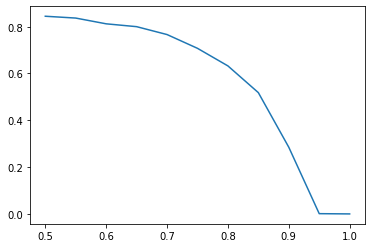

In [366]:
plt.plot(thresholds, f1_scores)
plt.show()

#### 4.2 Final Logistic Regression Model

In [367]:
BEST_THRESHOLD = 0.6

In [471]:
fg_model, f1 = log_reg(X_prep_fg, y_fg, 0.6)


Confusion Matrix (t=0.6)
[[ 264  429]
 [ 277 1537]]
F1: 0.8132275132275132


### 5.0 Punt Distributions

In [369]:
PUNTS = d.loc[d['pff_SPECIALTEAMSTYPE'] == 'PUNT'][['pff_KICKYARDS', 'pff_RETURNYARDS']]
PUNTS['pff_RETURNYARDS'] = PUNTS['pff_RETURNYARDS'].fillna(0)
PUNTS = PUNTS.dropna()

In [370]:
PUNTS.shape

(40766, 2)

In [371]:
PUNTS['NET_YARDS'] = PUNTS['pff_KICKYARDS'] - PUNTS['pff_RETURNYARDS']

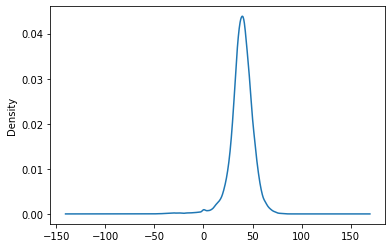

In [372]:
PUNTS['NET_YARDS'].plot.density()
plt.show()

In [373]:
x = np.array(PUNTS['NET_YARDS'])
punt_model = GaussianMixture(
        n_components=2,
#         random_state=SEED
).fit(x.reshape(-1, 1))

### 6.0 Run Models

In [374]:
RUN = RUN.drop('pff_PASSRESULT', axis=1)

In [375]:
r1 = RUN.loc[RUN['pff_DOWN'] == 1]
r2 = RUN.loc[RUN['pff_DOWN'] == 2]
r3 = RUN.loc[RUN['pff_DOWN'] == 3]
r4 = RUN.loc[RUN['pff_DOWN'] == 4]

In [376]:
print("Running Downs:")
print("\t1st:", r1.shape)
print("\t2nd:", r2.shape)
print("\t3rd:", r3.shape)
print("\t4th:", r4.shape)

Running Downs:
	1st: (97040, 9)
	2nd: (72009, 9)
	3rd: (45589, 9)
	4th: (4791, 9)


#### Calculate Median and Standard Deviation

In [377]:
r1['group'] = pd.qcut(r1['pff_DISTANCE'], q=[0, 0.05, 0.9675, 1], labels=['short', 'medium', 'long'])
r2['group'] = pd.qcut(r2['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
r3['group'] = pd.qcut(r3['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
r4['group'] = pd.qcut(r4['pff_DISTANCE'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])

In [378]:
r1_s, r1_m, r1_l = r1.loc[r1['group'] == 'short'], r1.loc[r1['group'] == 'medium'], r1.loc[r1['group'] == 'long']
r2_s, r2_m, r2_l = r2.loc[r2['group'] == 'short'], r2.loc[r2['group'] == 'medium'], r2.loc[r2['group'] == 'long']
r3_s, r3_m, r3_l = r3.loc[r3['group'] == 'short'], r3.loc[r3['group'] == 'medium'], r3.loc[r3['group'] == 'long']
r4_s, r4_m, r4_l = r4.loc[r4['group'] == 'short'], r4.loc[r4['group'] == 'medium'], r4.loc[r4['group'] == 'long']

In [379]:
print("Running Categories:")
print("\t1st:", r1.shape)
print("\t\t1st Short:", r1_s.shape)
print("\t\t1st Medium:", r1_m.shape)
print("\t\t1st Long:", r1_l.shape)
print("\t2nd:", r2.shape)
print("\t\t2nd Short:", r2_s.shape)
print("\t\t2nd Medium:", r2_m.shape)
print("\t\t2nd Long:", r2_l.shape)
print("\t3rd:", r3.shape)
print("\t\t3rd Short:", r3_s.shape)
print("\t\t3rd Medium:", r3_m.shape)
print("\t\t3rd Long:", r3_l.shape)
print("\t4th:", r4.shape)
print("\t\t4th Short:", r4_s.shape)
print("\t\t4th Medium:", r4_m.shape)
print("\t\t4th Long:", r4_l.shape)

Running Categories:
	1st: (97040, 10)
		1st Short: (5174, 10)
		1st Medium: (88732, 10)
		1st Long: (3134, 10)
	2nd: (72009, 10)
		2nd Short: (20932, 10)
		2nd Medium: (39981, 10)
		2nd Long: (11096, 10)
	3rd: (45589, 10)
		3rd Short: (11971, 10)
		3rd Medium: (25004, 10)
		3rd Long: (8614, 10)
	4th: (4791, 10)
		4th Short: (2822, 10)
		4th Medium: (890, 10)
		4th Long: (1079, 10)


#### Mixture Models

Ref: 
* [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)  
* [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
* [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

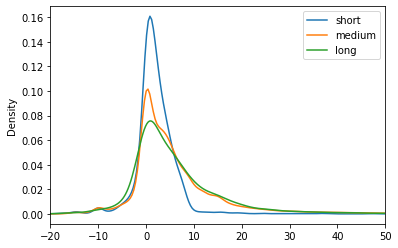

In [380]:
r1_s['pff_GAINLOSSNET'].plot.density()
r1_m['pff_GAINLOSSNET'].plot.density()
r1_l['pff_GAINLOSSNET'].plot.density()
plt.xlim(-20, 50)
plt.legend(labels=['short', 'medium', 'long'])
plt.show()

In [381]:
from sklearn.mixture import GaussianMixture

def plot_mixture(gm):
    """
    
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = np.linspace(-25, 50, 1000).reshape(1000, 1)
    logprob = gm.score_samples(x)
    pdf = np.exp(logprob)
    
    ax.plot(x, pdf, '-k')
    plt.show()
    

def mixture_model(x, plot=True):
    """
    
    """
    x = np.array(x['pff_GAINLOSSNET'])
    
    gm = GaussianMixture(
        n_components=2, 
#         random_state=SEED
    ).fit(x.reshape(-1, 1))
    
    if plot:
        plot_mixture(gm)
    
    return gm

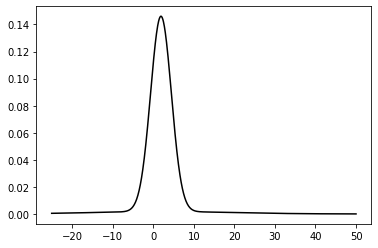

In [382]:
m = mixture_model(r1_s)

In [383]:
vals = [
    r1_s, r1_m, r1_l,
    r2_s, r2_m, r2_l,
    r3_s, r3_m, r3_l,
    r4_s, r4_m, r4_l
]
run_mixture_dict = {1: [], 2: [], 3: [], 4:[]}
run_bins = {1: [], 2: [], 3: [], 4:[]}

for i, v in enumerate(vals):
    down = i // 3 + 1
    
    m = mixture_model(v, plot=False)  
    run_mixture_dict[down].append(m)
    run_bins[down].append((min(v['pff_DISTANCE']), max(v['pff_DISTANCE']) + 1))

In [384]:
run_bins[1][0]

(1, 9)

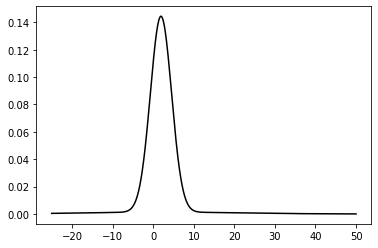

In [385]:
plot_mixture(run_mixture_dict[1][0])

In [413]:
run_mixture_dict[1][0].sample(1)[0][0][0]

3.0159673924615165

### 7.0 Pass Models

In [387]:
p1 = PASS.loc[PASS['pff_DOWN'] == 1]
p2 = PASS.loc[PASS['pff_DOWN'] == 2]
p3 = PASS.loc[PASS['pff_DOWN'] == 3]
p4 = PASS.loc[PASS['pff_DOWN'] == 4]

In [388]:
print("Passing Downs:")
print("\t1st:", p1.shape)
print("\t2nd:", p2.shape)
print("\t3rd:", p3.shape)
print("\t4th:", p4.shape)

Passing Downs:
	1st: (107268, 10)
	2nd: (79709, 10)
	3rd: (50658, 10)
	4th: (5458, 10)


#### Calculate Median and Standard Deviation

In [389]:
p1['group'] = pd.qcut(p1['pff_DISTANCE'], q=[0, 0.05, 0.9675, 1], labels=['short', 'medium', 'long'])
p2['group'] = pd.qcut(p2['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
p3['group'] = pd.qcut(p3['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
p4['group'] = pd.qcut(p4['pff_DISTANCE'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])

In [390]:
p1_s, p1_m, p1_l = p1.loc[p1['group'] == 'short'], p1.loc[p1['group'] == 'medium'], p1.loc[p1['group'] == 'long']
p2_s, p2_m, p2_l = p2.loc[p2['group'] == 'short'], p2.loc[p2['group'] == 'medium'], p2.loc[p2['group'] == 'long']
p3_s, p3_m, p3_l = p3.loc[p3['group'] == 'short'], p3.loc[p3['group'] == 'medium'], p3.loc[p3['group'] == 'long']
p4_s, p4_m, p4_l = p4.loc[p4['group'] == 'short'], p4.loc[p4['group'] == 'medium'], p4.loc[p4['group'] == 'long']

In [391]:
print("Passing Categories:")
print("\t1st:", p1.shape)
print("\t\t1st Short:", p1_s.shape)
print("\t\t1st Medium:", p1_m.shape)
print("\t\t1st Long:", p1_l.shape)
print("\t2nd:", p2.shape)
print("\t\t2nd Short:", p2_s.shape)
print("\t\t2nd Medium:", p2_m.shape)
print("\t\t2nd Long:", p2_l.shape)
print("\t3rd:", p3.shape)
print("\t\t3rd Short:", p3_s.shape)
print("\t\t3rd Medium:", p3_m.shape)
print("\t\t3rd Long:", p3_l.shape)
print("\t4th:", p4.shape)
print("\t\t4th Short:", p4_s.shape)
print("\t\t4th Medium:", p4_m.shape)
print("\t\t4th Long:", p4_l.shape)

Passing Categories:
	1st: (107268, 11)
		1st Short: (5805, 11)
		1st Medium: (97980, 11)
		1st Long: (3483, 11)
	2nd: (79709, 11)
		2nd Short: (22968, 11)
		2nd Medium: (44671, 11)
		2nd Long: (12070, 11)
	3rd: (50658, 11)
		3rd Short: (13279, 11)
		3rd Medium: (27986, 11)
		3rd Long: (9393, 11)
	4th: (5458, 11)
		4th Short: (2734, 11)
		4th Medium: (1500, 11)
		4th Long: (1224, 11)


In [392]:
vals = [
    p1_s, p1_m, p1_l,
    p2_s, p2_m, p2_l,
    p3_s, p3_m, p3_l,
    p4_s, p4_m, p4_l
]
pass_mixture_dict = {1: [], 2: [], 3: [], 4:[]}
pass_bins = {1: [], 2: [], 3: [], 4:[]}

for i, v in enumerate(vals):
    down = i // 3 + 1
    
    m = mixture_model(v, plot=False)  
    pass_mixture_dict[down].append(m)
    pass_bins[down].append((min(v['pff_DISTANCE']), max(v['pff_DISTANCE']) + 1))

In [393]:
pass_bins[1][0]

(1, 9)

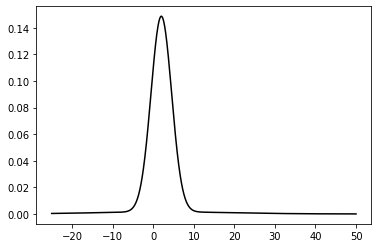

In [394]:
plot_mixture(pass_mixture_dict[1][0])

### 8.0 Expected Points Added Model

In [430]:
SEED = 42
PCT_RUN = 0.5
AGGRESSION = 0

In [526]:
def EPA(down, ytg, position, own):
    """
    @param - down:
    @param - ytg:
    @param - position:
    @param - own:
    """
    global reverse
    
    points = list()
    position = 100 - position if not own else position
    
    SIMULATIONS = 1000
    for i in range(SIMULATIONS):
        reverse = False
        
        point = run_play(down, ytg, position)
        points.append(point)
    
    return np.array(points).mean()

In [527]:
def run_play(down, ytg, position):
    """
    @param - down:
    @param - ytg:
    @param - position:
    """
    global reverse
    
    choices = ['run', 'pass']
    choice = np.random.choice(choices, 1, p=[PCT_RUN, 1 - PCT_RUN])[0]

    bins = run_bins if choice == 'run' else pass_bins
    models = run_mixture_dict if choice == 'run' else pass_mixture_dict
    
    try:
        idx = [i for i, b in enumerate(bins[down]) if ytg in range(b[1])][0]
    except IndexError:
        idx = 2
    
    model = models[down][idx]
    
    print(down, ytg, position)
    
    if down == 4:
        # Go For It
        if AGGRESSION >= idx and position > 40:
            yards_gained = round(model.sample(1)[0][0][0], 0)
            position += yards_gained
            
            # Converted
            if yards_gained >= ytg:
                down, ytg = 1, 10
                print("\tConverted:", yards_gained, "yards gained")
                return run_play(down, ytg, position)
            
            # Turnover on Downs
            else:
                reverse = not reverse
                down, ytg = 1, 10
                print("\tTurnover on Downs:", yards_gained, "yards gained")
                return run_play(down, ytg, 100 - position)
                
        # Field Goal
        elif (position >= 60) or (50 >= position < 60 and AGGRESSION == 2):
            hash_ = list(np.zeros(3))
            hash_[np.random.randint(0, 3)] = 1
            hash_.extend([100 - position + 17])
            result = fg_model.predict(np.array(hash_).reshape(1, -1))[0]
            
            print('Kicking Field Goal...')
            if result == 0:
                reverse = not reverse
                down, ytg = 1, 10
                return run_play(down, ytg, 100 - position)
            else:
                score = True
                scored = 3
            
        # Punt
        else:
            net_yards = round(punt_model.sample(1)[0][0][0], 0)
            position += net_yards
            
            print('Punting...', net_yards)
            # Punt Returned for TD
            if position < 0:
                score = True
                scored = -7
            # Touchback
            elif position >= 100:
                down, ytg = 1, 10
                return run_play(down, ytg, 25)
            else:
                reverse = not reverse
                down, ytg = 1, 10
                return run_play(down, ytg, 100 - position)
        
    else:
        yards_gained = round(model.sample(1)[0][0][0], 0)
        position += yards_gained
        print("\t", yards_gained, "yards gained")
        
        # Touchdown
        if position >= 100:
            print('TOUCHDOWN!')
            score = True
            scored = 7
            
        # Safety
        elif position <= 0:
            print('SAFETY!')
            score = True
            scored = -2
            
        # First Down
        elif yards_gained >= ytg:
            down, ytg = 1, 10
            return run_play(down, ytg, position)
        else:
            return run_play(down + 1, ytg - yards_gained, position)
    
    ret = scored if not reverse else -scored
    print(ret)
    return ret

In [529]:
down = int(input('Down: ').strip())
ytg = int(input('Yards to Go: ').strip())
position = int(input('Field Position: ').strip())
own = input('Possession (home/away): ').strip()
own = True if own == 'home' else False

In [530]:
down = 4
ytg = 1
position = 1
own = True

In [531]:
STATE = {
    'down': down,
    'ytg': ytg,
    'position': position,
    'own': own
}

In [532]:
epa = EPA(**STATE)

4 1 1
Punting... 30.0
1 10 69.0
	 1.0 yards gained
2 9.0 70.0
	 8.0 yards gained
3 1.0 78.0
	 7.0 yards gained
1 10 85.0
	 -2.0 yards gained
2 12.0 83.0
	 -8.0 yards gained
3 20.0 75.0
	 -0.0 yards gained
4 20.0 75.0
Kicking Field Goal...
-3
4 1 1
Punting... 23.0
1 10 76.0
	 5.0 yards gained
2 5.0 81.0
	 7.0 yards gained
1 10 88.0
	 10.0 yards gained
1 10 98.0
	 2.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 38.0
1 10 61.0
	 -2.0 yards gained
2 12.0 59.0
	 6.0 yards gained
3 6.0 65.0
	 23.0 yards gained
1 10 88.0
	 -2.0 yards gained
2 12.0 86.0
	 3.0 yards gained
3 9.0 89.0
	 3.0 yards gained
4 6.0 92.0
Kicking Field Goal...
-3
4 1 1
Punting... 45.0
1 10 54.0
	 2.0 yards gained
2 8.0 56.0
	 44.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 35.0
1 10 64.0
	 6.0 yards gained
2 4.0 70.0
	 1.0 yards gained
3 3.0 71.0
	 11.0 yards gained
1 10 82.0
	 5.0 yards gained
2 5.0 87.0
	 -14.0 yards gained
3 19.0 73.0
	 12.0 yards gained
4 7.0 85.0
Kicking Field Goal...
-3
4 1 1
Punting... 37.0
1 10

	 -4.0 yards gained
2 14.0 55.0
	 2.0 yards gained
3 12.0 57.0
	 5.0 yards gained
4 7.0 62.0
Kicking Field Goal...
1 10 38.0
	 3.0 yards gained
2 7.0 41.0
	 9.0 yards gained
1 10 50.0
	 -1.0 yards gained
2 11.0 49.0
	 9.0 yards gained
3 2.0 58.0
	 -4.0 yards gained
4 6.0 54.0
Punting... 34.0
1 10 12.0
	 29.0 yards gained
1 10 41.0
	 5.0 yards gained
2 5.0 46.0
	 14.0 yards gained
1 10 60.0
	 1.0 yards gained
2 9.0 61.0
	 7.0 yards gained
3 2.0 68.0
	 7.0 yards gained
1 10 75.0
	 6.0 yards gained
2 4.0 81.0
	 -0.0 yards gained
3 4.0 81.0
	 -6.0 yards gained
4 10.0 75.0
Kicking Field Goal...
-3
4 1 1
Punting... 25.0
1 10 74.0
	 57.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 34.0
1 10 65.0
	 -1.0 yards gained
2 11.0 64.0
	 9.0 yards gained
3 2.0 73.0
	 5.0 yards gained
1 10 78.0
	 9.0 yards gained
2 1.0 87.0
	 6.0 yards gained
1 10 93.0
	 4.0 yards gained
2 6.0 97.0
	 11.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 32.0
1 10 67.0
	 5.0 yards gained
2 5.0 72.0
	 6.0 yards gained
1 10 78

	 7.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 41.0
1 10 58.0
	 10.0 yards gained
1 10 68.0
	 6.0 yards gained
2 4.0 74.0
	 0.0 yards gained
3 4.0 74.0
	 1.0 yards gained
4 3.0 75.0
	Converted: 4.0 yards gained
1 10 79.0
	 -2.0 yards gained
2 12.0 77.0
	 8.0 yards gained
3 4.0 85.0
	 45.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 45.0
1 10 54.0
	 2.0 yards gained
2 8.0 56.0
	 -11.0 yards gained
3 19.0 45.0
	 -5.0 yards gained
4 24.0 40.0
Punting... 6.0
1 10 54.0
	 -3.0 yards gained
2 13.0 51.0
	 5.0 yards gained
3 8.0 56.0
	 4.0 yards gained
4 4.0 60.0
Kicking Field Goal...
1 10 40.0
	 6.0 yards gained
2 4.0 46.0
	 -2.0 yards gained
3 6.0 44.0
	 6.0 yards gained
1 10 50.0
	 2.0 yards gained
2 8.0 52.0
	 -5.0 yards gained
3 13.0 47.0
	 39.0 yards gained
1 10 86.0
	 11.0 yards gained
1 10 97.0
	 7.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 36.0
1 10 63.0
	 5.0 yards gained
2 5.0 68.0
	 0.0 yards gained
3 5.0 68.0
	 4.0 yards gained
4 1.0 72.0
	Turnover on Downs: -17.0 yards gaine

1 10 33.0
	 -6.0 yards gained
2 16.0 27.0
	 4.0 yards gained
3 12.0 31.0
	 2.0 yards gained
4 10.0 33.0
Punting... 33.0
1 10 34.0
	 3.0 yards gained
2 7.0 37.0
	 -1.0 yards gained
3 8.0 36.0
	 8.0 yards gained
1 10 44.0
	 -1.0 yards gained
2 11.0 43.0
	 -1.0 yards gained
3 12.0 42.0
	 38.0 yards gained
1 10 80.0
	 3.0 yards gained
2 7.0 83.0
	 9.0 yards gained
1 10 92.0
	 -1.0 yards gained
2 11.0 91.0
	 -1.0 yards gained
3 12.0 90.0
	 34.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 29.0
1 10 70.0
	 1.0 yards gained
2 9.0 71.0
	 8.0 yards gained
3 1.0 79.0
	 2.0 yards gained
1 10 81.0
	 4.0 yards gained
2 6.0 85.0
	 6.0 yards gained
1 10 91.0
	 0.0 yards gained
2 10.0 91.0
	 -3.0 yards gained
3 13.0 88.0
	 3.0 yards gained
4 10.0 91.0
Kicking Field Goal...
-3
4 1 1
Punting... 8.0
1 10 91.0
	 8.0 yards gained
2 2.0 99.0
	 8.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 40.0
1 10 59.0
	 5.0 yards gained
2 5.0 64.0
	 4.0 yards gained
3 1.0 68.0
	 -6.0 yards gained
4 7.0 62.0
Kicking Field

2 6.0 62.0
	 -5.0 yards gained
3 11.0 57.0
	 -1.0 yards gained
4 12.0 56.0
Punting... 33.0
1 10 11.0
	 5.0 yards gained
2 5.0 16.0
	 -3.0 yards gained
3 8.0 13.0
	 -3.0 yards gained
4 11.0 10.0
Punting... 35.0
1 10 55.0
	 7.0 yards gained
2 3.0 62.0
	 5.0 yards gained
1 10 67.0
	 8.0 yards gained
2 2.0 75.0
	 5.0 yards gained
1 10 80.0
	 -8.0 yards gained
2 18.0 72.0
	 1.0 yards gained
3 17.0 73.0
	 0.0 yards gained
4 17.0 73.0
Kicking Field Goal...
-3
4 1 1
Punting... 34.0
1 10 65.0
	 10.0 yards gained
1 10 75.0
	 7.0 yards gained
2 3.0 82.0
	 -5.0 yards gained
3 8.0 77.0
	 7.0 yards gained
4 1.0 84.0
	Converted: 29.0 yards gained
1 10 113.0
	 1.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 38.0
1 10 61.0
	 -3.0 yards gained
2 13.0 58.0
	 1.0 yards gained
3 12.0 59.0
	 28.0 yards gained
1 10 87.0
	 39.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 55.0
1 10 44.0
	 4.0 yards gained
2 6.0 48.0
	 2.0 yards gained
3 4.0 50.0
	 24.0 yards gained
1 10 74.0
	 -0.0 yards gained
2 10.0 74.0
	 4

	 23.0 yards gained
1 10 63.0
	 -4.0 yards gained
2 14.0 59.0
	 4.0 yards gained
3 10.0 63.0
	 3.0 yards gained
4 7.0 66.0
Kicking Field Goal...
1 10 34.0
	 7.0 yards gained
2 3.0 41.0
	 4.0 yards gained
1 10 45.0
	 5.0 yards gained
2 5.0 50.0
	 4.0 yards gained
3 1.0 54.0
	 3.0 yards gained
1 10 57.0
	 27.0 yards gained
1 10 84.0
	 -5.0 yards gained
2 15.0 79.0
	 11.0 yards gained
3 4.0 90.0
	 8.0 yards gained
1 10 98.0
	 20.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 46.0
1 10 53.0
	 3.0 yards gained
2 7.0 56.0
	 2.0 yards gained
3 5.0 58.0
	 23.0 yards gained
1 10 81.0
	 -4.0 yards gained
2 14.0 77.0
	 -4.0 yards gained
3 18.0 73.0
	 40.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 30.0
1 10 69.0
	 1.0 yards gained
2 9.0 70.0
	 7.0 yards gained
3 2.0 77.0
	 18.0 yards gained
1 10 95.0
	 6.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 46.0
1 10 53.0
	 2.0 yards gained
2 8.0 55.0
	 28.0 yards gained
1 10 83.0
	 -2.0 yards gained
2 12.0 81.0
	 8.0 yards gained
3 4.0 89.0
	 6.0 yards g

	 4.0 yards gained
2 6.0 52.0
	 22.0 yards gained
1 10 74.0
	 -3.0 yards gained
2 13.0 71.0
	 -3.0 yards gained
3 16.0 68.0
	 0.0 yards gained
4 16.0 68.0
Kicking Field Goal...
1 10 32.0
	 10.0 yards gained
1 10 42.0
	 11.0 yards gained
1 10 53.0
	 2.0 yards gained
2 8.0 55.0
	 6.0 yards gained
3 2.0 61.0
	 1.0 yards gained
4 1.0 62.0
	Converted: 1.0 yards gained
1 10 63.0
	 -0.0 yards gained
2 10.0 63.0
	 -2.0 yards gained
3 12.0 61.0
	 -1.0 yards gained
4 13.0 60.0
Kicking Field Goal...
1 10 40.0
	 2.0 yards gained
2 8.0 42.0
	 8.0 yards gained
1 10 50.0
	 45.0 yards gained
1 10 95.0
	 5.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 33.0
1 10 66.0
	 3.0 yards gained
2 7.0 69.0
	 2.0 yards gained
3 5.0 71.0
	 14.0 yards gained
1 10 85.0
	 6.0 yards gained
2 4.0 91.0
	 -5.0 yards gained
3 9.0 86.0
	 -4.0 yards gained
4 13.0 82.0
Kicking Field Goal...
-3
4 1 1
Punting... 50.0
1 10 49.0
	 8.0 yards gained
2 2.0 57.0
	 2.0 yards gained
1 10 59.0
	 -1.0 yards gained
2 11.0 58.0
	 4.0 yards 

	 -0.0 yards gained
2 10.0 28.0
	 2.0 yards gained
3 8.0 30.0
	 -3.0 yards gained
4 11.0 27.0
Punting... 31.0
1 10 42.0
	 -2.0 yards gained
2 12.0 40.0
	 6.0 yards gained
3 6.0 46.0
	 4.0 yards gained
4 2.0 50.0
	Turnover on Downs: 0.0 yards gained
1 10 50.0
	 2.0 yards gained
2 8.0 52.0
	 6.0 yards gained
3 2.0 58.0
	 4.0 yards gained
1 10 62.0
	 2.0 yards gained
2 8.0 64.0
	 13.0 yards gained
1 10 77.0
	 -4.0 yards gained
2 14.0 73.0
	 4.0 yards gained
3 10.0 77.0
	 -2.0 yards gained
4 12.0 75.0
Kicking Field Goal...
3
4 1 1
Punting... 47.0
1 10 52.0
	 3.0 yards gained
2 7.0 55.0
	 7.0 yards gained
1 10 62.0
	 7.0 yards gained
2 3.0 69.0
	 7.0 yards gained
1 10 76.0
	 7.0 yards gained
2 3.0 83.0
	 27.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 37.0
1 10 62.0
	 8.0 yards gained
2 2.0 70.0
	 -3.0 yards gained
3 5.0 67.0
	 3.0 yards gained
4 2.0 70.0
	Converted: 8.0 yards gained
1 10 78.0
	 3.0 yards gained
2 7.0 81.0
	 10.0 yards gained
1 10 91.0
	 -5.0 yards gained
2 15.0 86.0
	 49.

1 10 1.0
	 -4.0 yards gained
SAFETY!
-2
4 1 1
Punting... 29.0
1 10 70.0
	 5.0 yards gained
2 5.0 75.0
	 2.0 yards gained
3 3.0 77.0
	 5.0 yards gained
1 10 82.0
	 30.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 44.0
1 10 55.0
	 9.0 yards gained
2 1.0 64.0
	 2.0 yards gained
1 10 66.0
	 4.0 yards gained
2 6.0 70.0
	 1.0 yards gained
3 5.0 71.0
	 -1.0 yards gained
4 6.0 70.0
Kicking Field Goal...
-3
4 1 1
Punting... 32.0
1 10 67.0
	 5.0 yards gained
2 5.0 72.0
	 0.0 yards gained
3 5.0 72.0
	 24.0 yards gained
1 10 96.0
	 0.0 yards gained
2 10.0 96.0
	 -0.0 yards gained
3 10.0 96.0
	 3.0 yards gained
4 7.0 99.0
Kicking Field Goal...
-3
4 1 1
Punting... 39.0
1 10 60.0
	 -5.0 yards gained
2 15.0 55.0
	 1.0 yards gained
3 14.0 56.0
	 -1.0 yards gained
4 15.0 55.0
Punting... 40.0
1 10 5.0
	 7.0 yards gained
2 3.0 12.0
	 5.0 yards gained
1 10 17.0
	 1.0 yards gained
2 9.0 18.0
	 -0.0 yards gained
3 9.0 18.0
	 2.0 yards gained
4 7.0 20.0
Punting... 52.0
1 10 28.0
	 4.0 yards gained
2 6.0 32.0


1 10 82.0
	 7.0 yards gained
2 3.0 89.0
	 3.0 yards gained
1 10 92.0
	 -1.0 yards gained
2 11.0 91.0
	 11.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 41.0
1 10 58.0
	 14.0 yards gained
1 10 72.0
	 5.0 yards gained
2 5.0 77.0
	 3.0 yards gained
3 2.0 80.0
	 3.0 yards gained
1 10 83.0
	 2.0 yards gained
2 8.0 85.0
	 2.0 yards gained
3 6.0 87.0
	 4.0 yards gained
4 2.0 91.0
	Turnover on Downs: 1.0 yards gained
1 10 8.0
	 8.0 yards gained
2 2.0 16.0
	 5.0 yards gained
1 10 21.0
	 -3.0 yards gained
2 13.0 18.0
	 -4.0 yards gained
3 17.0 14.0
	 11.0 yards gained
4 6.0 25.0
Punting... 45.0
1 10 30.0
	 -0.0 yards gained
2 10.0 30.0
	 7.0 yards gained
3 3.0 37.0
	 3.0 yards gained
1 10 40.0
	 4.0 yards gained
2 6.0 44.0
	 3.0 yards gained
3 3.0 47.0
	 2.0 yards gained
4 1.0 49.0
	Converted: 5.0 yards gained
1 10 54.0
	 -2.0 yards gained
2 12.0 52.0
	 -7.0 yards gained
3 19.0 45.0
	 -1.0 yards gained
4 20.0 44.0
Punting... 40.0
1 10 16.0
	 4.0 yards gained
2 6.0 20.0
	 3.0 yards gained
3 3.0 2

4 3.0 79.0
Kicking Field Goal...
-3
4 1 1
Punting... 44.0
1 10 55.0
	 -1.0 yards gained
2 11.0 54.0
	 31.0 yards gained
1 10 85.0
	 -1.0 yards gained
2 11.0 84.0
	 7.0 yards gained
3 4.0 91.0
	 -1.0 yards gained
4 5.0 90.0
Kicking Field Goal...
-3
4 1 1
Punting... 50.0
1 10 49.0
	 3.0 yards gained
2 7.0 52.0
	 -3.0 yards gained
3 10.0 49.0
	 3.0 yards gained
4 7.0 52.0
Punting... 43.0
1 10 5.0
	 4.0 yards gained
2 6.0 9.0
	 1.0 yards gained
3 5.0 10.0
	 3.0 yards gained
4 2.0 13.0
Punting... 48.0
1 10 39.0
	 7.0 yards gained
2 3.0 46.0
	 2.0 yards gained
3 1.0 48.0
	 2.0 yards gained
1 10 50.0
	 3.0 yards gained
2 7.0 53.0
	 -1.0 yards gained
3 8.0 52.0
	 3.0 yards gained
4 5.0 55.0
Punting... 43.0
1 10 2.0
	 0.0 yards gained
2 10.0 2.0
	 2.0 yards gained
3 8.0 4.0
	 23.0 yards gained
1 10 27.0
	 26.0 yards gained
1 10 53.0
	 69.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 45.0
1 10 54.0
	 4.0 yards gained
2 6.0 58.0
	 6.0 yards gained
1 10 64.0
	 4.0 yards gained
2 6.0 68.0
	 16.0 yar

	 -1.0 yards gained
2 11.0 58.0
	 9.0 yards gained
3 2.0 67.0
	 0.0 yards gained
4 2.0 67.0
	Turnover on Downs: 1.0 yards gained
1 10 32.0
	 -6.0 yards gained
2 16.0 26.0
	 -2.0 yards gained
3 18.0 24.0
	 16.0 yards gained
4 2.0 40.0
Punting... 33.0
1 10 27.0
	 17.0 yards gained
1 10 44.0
	 -6.0 yards gained
2 16.0 38.0
	 2.0 yards gained
3 14.0 40.0
	 -3.0 yards gained
4 17.0 37.0
Punting... 37.0
1 10 26.0
	 8.0 yards gained
2 2.0 34.0
	 3.0 yards gained
1 10 37.0
	 11.0 yards gained
1 10 48.0
	 -1.0 yards gained
2 11.0 47.0
	 7.0 yards gained
3 4.0 54.0
	 11.0 yards gained
1 10 65.0
	 10.0 yards gained
1 10 75.0
	 2.0 yards gained
2 8.0 77.0
	 13.0 yards gained
1 10 90.0
	 3.0 yards gained
2 7.0 93.0
	 2.0 yards gained
3 5.0 95.0
	 -2.0 yards gained
4 7.0 93.0
Kicking Field Goal...
3
4 1 1
Punting... 40.0
1 10 59.0
	 10.0 yards gained
1 10 69.0
	 6.0 yards gained
2 4.0 75.0
	 4.0 yards gained
1 10 79.0
	 7.0 yards gained
2 3.0 86.0
	 40.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 3

Kicking Field Goal...
-3
4 1 1
Punting... 47.0
1 10 52.0
	 5.0 yards gained
2 5.0 57.0
	 7.0 yards gained
1 10 64.0
	 0.0 yards gained
2 10.0 64.0
	 4.0 yards gained
3 6.0 68.0
	 5.0 yards gained
4 1.0 73.0
	Converted: 4.0 yards gained
1 10 77.0
	 1.0 yards gained
2 9.0 78.0
	 -1.0 yards gained
3 10.0 77.0
	 2.0 yards gained
4 8.0 79.0
Kicking Field Goal...
-3
4 1 1
Punting... 46.0
1 10 53.0
	 1.0 yards gained
2 9.0 54.0
	 3.0 yards gained
3 6.0 57.0
	 -7.0 yards gained
4 13.0 50.0
Punting... 23.0
1 10 27.0
	 -4.0 yards gained
2 14.0 23.0
	 -1.0 yards gained
3 15.0 22.0
	 -4.0 yards gained
4 19.0 18.0
Punting... 40.0
1 10 42.0
	 2.0 yards gained
2 8.0 44.0
	 4.0 yards gained
3 4.0 48.0
	 -2.0 yards gained
4 6.0 46.0
Punting... 32.0
1 10 22.0
	 -3.0 yards gained
2 13.0 19.0
	 5.0 yards gained
3 8.0 24.0
	 9.0 yards gained
1 10 33.0
	 1.0 yards gained
2 9.0 34.0
	 -1.0 yards gained
3 10.0 33.0
	 8.0 yards gained
4 2.0 41.0
	Converted: 4.0 yards gained
1 10 45.0
	 1.0 yards gained
2 9.0 4

	 -3.0 yards gained
3 14.0 75.0
	 6.0 yards gained
4 8.0 81.0
Kicking Field Goal...
-3
4 1 1
Punting... 35.0
1 10 64.0
	 0.0 yards gained
2 10.0 64.0
	 5.0 yards gained
3 5.0 69.0
	 4.0 yards gained
4 1.0 73.0
	Converted: 1.0 yards gained
1 10 74.0
	 -3.0 yards gained
2 13.0 71.0
	 -0.0 yards gained
3 13.0 71.0
	 10.0 yards gained
4 3.0 81.0
Kicking Field Goal...
-3
4 1 1
Punting... 36.0
1 10 63.0
	 -0.0 yards gained
2 10.0 63.0
	 6.0 yards gained
3 4.0 69.0
	 -6.0 yards gained
4 10.0 63.0
Kicking Field Goal...
1 10 37.0
	 9.0 yards gained
2 1.0 46.0
	 29.0 yards gained
1 10 75.0
	 5.0 yards gained
2 5.0 80.0
	 -0.0 yards gained
3 5.0 80.0
	 4.0 yards gained
4 1.0 84.0
	Converted: 2.0 yards gained
1 10 86.0
	 2.0 yards gained
2 8.0 88.0
	 -3.0 yards gained
3 11.0 85.0
	 26.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 39.0
1 10 60.0
	 9.0 yards gained
2 1.0 69.0
	 -5.0 yards gained
3 6.0 64.0
	 -1.0 yards gained
4 7.0 63.0
Kicking Field Goal...
1 10 37.0
	 3.0 yards gained
2 7.0 40.0
	 

	 0.0 yards gained
3 1.0 72.0
	 27.0 yards gained
1 10 99.0
	 4.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 11.0
1 10 88.0
	 4.0 yards gained
2 6.0 92.0
	 30.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 39.0
1 10 60.0
	 6.0 yards gained
2 4.0 66.0
	 11.0 yards gained
1 10 77.0
	 10.0 yards gained
1 10 87.0
	 -8.0 yards gained
2 18.0 79.0
	 0.0 yards gained
3 18.0 79.0
	 -11.0 yards gained
4 29.0 68.0
Kicking Field Goal...
-3
4 1 1
Punting... 45.0
1 10 54.0
	 -2.0 yards gained
2 12.0 52.0
	 5.0 yards gained
3 7.0 57.0
	 3.0 yards gained
4 4.0 60.0
Kicking Field Goal...
1 10 40.0
	 6.0 yards gained
2 4.0 46.0
	 5.0 yards gained
1 10 51.0
	 3.0 yards gained
2 7.0 54.0
	 6.0 yards gained
3 1.0 60.0
	 5.0 yards gained
1 10 65.0
	 16.0 yards gained
1 10 81.0
	 3.0 yards gained
2 7.0 84.0
	 5.0 yards gained
3 2.0 89.0
	 -4.0 yards gained
4 6.0 85.0
Kicking Field Goal...
3
4 1 1
Punting... 31.0
1 10 68.0
	 -12.0 yards gained
2 22.0 56.0
	 -2.0 yards gained
3 24.0 54.0
	 4.0 yards gained
4 2

	 3.0 yards gained
2 7.0 37.0
	 6.0 yards gained
3 1.0 43.0
	 2.0 yards gained
1 10 45.0
	 45.0 yards gained
1 10 90.0
	 -9.0 yards gained
2 19.0 81.0
	 12.0 yards gained
3 7.0 93.0
	 4.0 yards gained
4 3.0 97.0
	Converted: 4.0 yards gained
1 10 101.0
	 34.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 40.0
1 10 59.0
	 -4.0 yards gained
2 14.0 55.0
	 31.0 yards gained
1 10 86.0
	 8.0 yards gained
2 2.0 94.0
	 3.0 yards gained
1 10 97.0
	 -2.0 yards gained
2 12.0 95.0
	 12.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 36.0
1 10 63.0
	 10.0 yards gained
1 10 73.0
	 -1.0 yards gained
2 11.0 72.0
	 -3.0 yards gained
3 14.0 69.0
	 9.0 yards gained
4 5.0 78.0
Kicking Field Goal...
-3
4 1 1
Punting... 40.0
1 10 59.0
	 -5.0 yards gained
2 15.0 54.0
	 10.0 yards gained
3 5.0 64.0
	 2.0 yards gained
4 3.0 66.0
	Converted: 4.0 yards gained
1 10 70.0
	 3.0 yards gained
2 7.0 73.0
	 -0.0 yards gained
3 7.0 73.0
	 -5.0 yards gained
4 12.0 68.0
Kicking Field Goal...
1 10 32.0
	 3.0 yards gained
2 7.0 3

Kicking Field Goal...
-3
4 1 1
Punting... 44.0
1 10 55.0
	 9.0 yards gained
2 1.0 64.0
	 1.0 yards gained
1 10 65.0
	 2.0 yards gained
2 8.0 67.0
	 7.0 yards gained
3 1.0 74.0
	 3.0 yards gained
1 10 77.0
	 19.0 yards gained
1 10 96.0
	 -2.0 yards gained
2 12.0 94.0
	 8.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 40.0
1 10 59.0
	 6.0 yards gained
2 4.0 65.0
	 7.0 yards gained
1 10 72.0
	 -2.0 yards gained
2 12.0 70.0
	 5.0 yards gained
3 7.0 75.0
	 3.0 yards gained
4 4.0 78.0
Kicking Field Goal...
-3
4 1 1
Punting... 44.0
1 10 55.0
	 2.0 yards gained
2 8.0 57.0
	 -5.0 yards gained
3 13.0 52.0
	 -1.0 yards gained
4 14.0 51.0
Punting... 33.0
1 10 16.0
	 -2.0 yards gained
2 12.0 14.0
	 5.0 yards gained
3 7.0 19.0
	 7.0 yards gained
1 10 26.0
	 1.0 yards gained
2 9.0 27.0
	 8.0 yards gained
3 1.0 35.0
	 -2.0 yards gained
4 3.0 33.0
Punting... 24.0
1 10 43.0
	 4.0 yards gained
2 6.0 47.0
	 -7.0 yards gained
3 13.0 40.0
	 3.0 yards gained
4 10.0 43.0
Punting... 53.0
1 10 4.0
	 6.0 yards ga

	 11.0 yards gained
1 10 87.0
	 1.0 yards gained
2 9.0 88.0
	 8.0 yards gained
3 1.0 96.0
	 5.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 39.0
1 10 60.0
	 10.0 yards gained
1 10 70.0
	 10.0 yards gained
1 10 80.0
	 5.0 yards gained
2 5.0 85.0
	 9.0 yards gained
1 10 94.0
	 -2.0 yards gained
2 12.0 92.0
	 7.0 yards gained
3 5.0 99.0
	 30.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 37.0
1 10 62.0
	 22.0 yards gained
1 10 84.0
	 -1.0 yards gained
2 11.0 83.0
	 -1.0 yards gained
3 12.0 82.0
	 20.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 49.0
1 10 50.0
	 -4.0 yards gained
2 14.0 46.0
	 -5.0 yards gained
3 19.0 41.0
	 3.0 yards gained
4 16.0 44.0
Punting... 11.0
1 10 45.0
	 7.0 yards gained
2 3.0 52.0
	 -0.0 yards gained
3 3.0 52.0
	 -29.0 yards gained
4 32.0 23.0
Punting... 34.0
1 10 43.0
	 6.0 yards gained
2 4.0 49.0
	 6.0 yards gained
1 10 55.0
	 8.0 yards gained
2 2.0 63.0
	 13.0 yards gained
1 10 76.0
	 17.0 yards gained
1 10 93.0
	 3.0 yards gained
2 7.0 96.0
	 15.0 yards gaine

Punting... 39.0
1 10 60.0
	 6.0 yards gained
2 4.0 66.0
	 7.0 yards gained
1 10 73.0
	 -8.0 yards gained
2 18.0 65.0
	 5.0 yards gained
3 13.0 70.0
	 5.0 yards gained
4 8.0 75.0
Kicking Field Goal...
-3
4 1 1
Punting... 36.0
1 10 63.0
	 1.0 yards gained
2 9.0 64.0
	 -4.0 yards gained
3 13.0 60.0
	 -3.0 yards gained
4 16.0 57.0
Punting... 47.0
1 10 25
	 -1.0 yards gained
2 11.0 24.0
	 -1.0 yards gained
3 12.0 23.0
	 2.0 yards gained
4 10.0 25.0
Punting... 44.0
1 10 31.0
	 46.0 yards gained
1 10 77.0
	 8.0 yards gained
2 2.0 85.0
	 2.0 yards gained
1 10 87.0
	 -1.0 yards gained
2 11.0 86.0
	 3.0 yards gained
3 8.0 89.0
	 2.0 yards gained
4 6.0 91.0
Kicking Field Goal...
3
4 1 1
Punting... 39.0
1 10 60.0
	 6.0 yards gained
2 4.0 66.0
	 3.0 yards gained
3 1.0 69.0
	 -2.0 yards gained
4 3.0 67.0
	Turnover on Downs: 2.0 yards gained
1 10 31.0
	 7.0 yards gained
2 3.0 38.0
	 9.0 yards gained
1 10 47.0
	 17.0 yards gained
1 10 64.0
	 7.0 yards gained
2 3.0 71.0
	 1.0 yards gained
3 2.0 72.0
	 

	 4.0 yards gained
1 10 98.0
	 5.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 37.0
1 10 62.0
	 -8.0 yards gained
2 18.0 54.0
	 9.0 yards gained
3 9.0 63.0
	 6.0 yards gained
4 3.0 69.0
Kicking Field Goal...
-3
4 1 1
Punting... 2.0
1 10 97.0
	 28.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 39.0
1 10 60.0
	 -2.0 yards gained
2 12.0 58.0
	 10.0 yards gained
3 2.0 68.0
	 6.0 yards gained
1 10 74.0
	 12.0 yards gained
1 10 86.0
	 2.0 yards gained
2 8.0 88.0
	 -1.0 yards gained
3 9.0 87.0
	 6.0 yards gained
4 3.0 93.0
	Turnover on Downs: 0.0 yards gained
1 10 7.0
	 9.0 yards gained
2 1.0 16.0
	 1.0 yards gained
1 10 17.0
	 10.0 yards gained
1 10 27.0
	 4.0 yards gained
2 6.0 31.0
	 35.0 yards gained
1 10 66.0
	 12.0 yards gained
1 10 78.0
	 4.0 yards gained
2 6.0 82.0
	 16.0 yards gained
1 10 98.0
	 3.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 69.0
1 10 30.0
	 4.0 yards gained
2 6.0 34.0
	 3.0 yards gained
3 3.0 37.0
	 1.0 yards gained
4 2.0 38.0
Punting... 38.0
1 10 24.0
	 6.0 yards ga

	 1.0 yards gained
4 5.0 65.0
Kicking Field Goal...
1 10 35.0
	 15.0 yards gained
1 10 50.0
	 7.0 yards gained
2 3.0 57.0
	 1.0 yards gained
3 2.0 58.0
	 5.0 yards gained
1 10 63.0
	 6.0 yards gained
2 4.0 69.0
	 5.0 yards gained
1 10 74.0
	 5.0 yards gained
2 5.0 79.0
	 51.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 44.0
1 10 55.0
	 4.0 yards gained
2 6.0 59.0
	 9.0 yards gained
1 10 68.0
	 -1.0 yards gained
2 11.0 67.0
	 6.0 yards gained
3 5.0 73.0
	 1.0 yards gained
4 4.0 74.0
Kicking Field Goal...
-3
4 1 1
Punting... 32.0
1 10 67.0
	 6.0 yards gained
2 4.0 73.0
	 4.0 yards gained
1 10 77.0
	 4.0 yards gained
2 6.0 81.0
	 1.0 yards gained
3 5.0 82.0
	 -3.0 yards gained
4 8.0 79.0
Kicking Field Goal...
-3
4 1 1
Punting... 36.0
1 10 63.0
	 7.0 yards gained
2 3.0 70.0
	 5.0 yards gained
1 10 75.0
	 -5.0 yards gained
2 15.0 70.0
	 4.0 yards gained
3 11.0 74.0
	 28.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 32.0
1 10 67.0
	 2.0 yards gained
2 8.0 69.0
	 -1.0 yards gained
3 9.0 68.0


2 3.0 23.0
	 -1.0 yards gained
3 4.0 22.0
	 5.0 yards gained
1 10 27.0
	 4.0 yards gained
2 6.0 31.0
	 -7.0 yards gained
3 13.0 24.0
	 0.0 yards gained
4 13.0 24.0
Punting... 63.0
1 10 13.0
	 6.0 yards gained
2 4.0 19.0
	 4.0 yards gained
1 10 23.0
	 4.0 yards gained
2 6.0 27.0
	 10.0 yards gained
1 10 37.0
	 6.0 yards gained
2 4.0 43.0
	 11.0 yards gained
1 10 54.0
	 -0.0 yards gained
2 10.0 54.0
	 5.0 yards gained
3 5.0 59.0
	 3.0 yards gained
4 2.0 62.0
	Converted: 3.0 yards gained
1 10 65.0
	 -1.0 yards gained
2 11.0 64.0
	 0.0 yards gained
3 11.0 64.0
	 -1.0 yards gained
4 12.0 63.0
Kicking Field Goal...
1 10 37.0
	 3.0 yards gained
2 7.0 40.0
	 -6.0 yards gained
3 13.0 34.0
	 4.0 yards gained
4 9.0 38.0
Punting... 47.0
1 10 15.0
	 1.0 yards gained
2 9.0 16.0
	 -2.0 yards gained
3 11.0 14.0
	 -3.0 yards gained
4 14.0 11.0
Punting... 40.0
1 10 49.0
	 9.0 yards gained
2 1.0 58.0
	 1.0 yards gained
1 10 59.0
	 7.0 yards gained
2 3.0 66.0
	 2.0 yards gained
3 1.0 68.0
	 10.0 yards gai

	 0.0 yards gained
2 10.0 54.0
	 -5.0 yards gained
3 15.0 49.0
	 -2.0 yards gained
4 17.0 47.0
Punting... 39.0
1 10 14.0
	 29.0 yards gained
1 10 43.0
	 -1.0 yards gained
2 11.0 42.0
	 4.0 yards gained
3 7.0 46.0
	 6.0 yards gained
4 1.0 52.0
	Converted: 1.0 yards gained
1 10 53.0
	 7.0 yards gained
2 3.0 60.0
	 6.0 yards gained
1 10 66.0
	 1.0 yards gained
2 9.0 67.0
	 12.0 yards gained
1 10 79.0
	 4.0 yards gained
2 6.0 83.0
	 2.0 yards gained
3 4.0 85.0
	 23.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 47.0
1 10 52.0
	 -6.0 yards gained
2 16.0 46.0
	 6.0 yards gained
3 10.0 52.0
	 12.0 yards gained
1 10 64.0
	 6.0 yards gained
2 4.0 70.0
	 1.0 yards gained
3 3.0 71.0
	 -2.0 yards gained
4 5.0 69.0
Kicking Field Goal...
-3
4 1 1
Punting... 35.0
1 10 64.0
	 3.0 yards gained
2 7.0 67.0
	 3.0 yards gained
3 4.0 70.0
	 17.0 yards gained
1 10 87.0
	 9.0 yards gained
2 1.0 96.0
	 -7.0 yards gained
3 8.0 89.0
	 2.0 yards gained
4 6.0 91.0
Kicking Field Goal...
-3
4 1 1
Punting... 48.0
1 10 

2 15.0 19.0
	 -1.0 yards gained
3 16.0 18.0
	 2.0 yards gained
4 14.0 20.0
Punting... 56.0
1 10 24.0
	 32.0 yards gained
1 10 56.0
	 10.0 yards gained
1 10 66.0
	 8.0 yards gained
2 2.0 74.0
	 6.0 yards gained
1 10 80.0
	 5.0 yards gained
2 5.0 85.0
	 3.0 yards gained
3 2.0 88.0
	 7.0 yards gained
1 10 95.0
	 -8.0 yards gained
2 18.0 87.0
	 1.0 yards gained
3 17.0 88.0
	 3.0 yards gained
4 14.0 91.0
Kicking Field Goal...
-3
4 1 1
Punting... 43.0
1 10 56.0
	 30.0 yards gained
1 10 86.0
	 -2.0 yards gained
2 12.0 84.0
	 14.0 yards gained
1 10 98.0
	 -5.0 yards gained
2 15.0 93.0
	 13.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 34.0
1 10 65.0
	 1.0 yards gained
2 9.0 66.0
	 -2.0 yards gained
3 11.0 64.0
	 3.0 yards gained
4 8.0 67.0
Kicking Field Goal...
-3
4 1 1
Punting... 51.0
1 10 48.0
	 -11.0 yards gained
2 21.0 37.0
	 -0.0 yards gained
3 21.0 37.0
	 -7.0 yards gained
4 28.0 30.0
Punting... 40.0
1 10 30.0
	 6.0 yards gained
2 4.0 36.0
	 1.0 yards gained
3 3.0 37.0
	 7.0 yards gained

1 10 70.0
	 -4.0 yards gained
2 14.0 66.0
	 3.0 yards gained
3 11.0 69.0
	 -0.0 yards gained
4 11.0 69.0
Kicking Field Goal...
1 10 31.0
	 -2.0 yards gained
2 12.0 29.0
	 10.0 yards gained
3 2.0 39.0
	 -2.0 yards gained
4 4.0 37.0
Punting... 31.0
1 10 32.0
	 7.0 yards gained
2 3.0 39.0
	 1.0 yards gained
3 2.0 40.0
	 4.0 yards gained
1 10 44.0
	 9.0 yards gained
2 1.0 53.0
	 13.0 yards gained
1 10 66.0
	 2.0 yards gained
2 8.0 68.0
	 7.0 yards gained
3 1.0 75.0
	 7.0 yards gained
1 10 82.0
	 7.0 yards gained
2 3.0 89.0
	 -3.0 yards gained
3 6.0 86.0
	 5.0 yards gained
4 1.0 91.0
	Converted: 3.0 yards gained
1 10 94.0
	 -1.0 yards gained
2 11.0 93.0
	 -2.0 yards gained
3 13.0 91.0
	 4.0 yards gained
4 9.0 95.0
Kicking Field Goal...
-3
4 1 1
Punting... 27.0
1 10 72.0
	 4.0 yards gained
2 6.0 76.0
	 5.0 yards gained
3 1.0 81.0
	 1.0 yards gained
1 10 82.0
	 -4.0 yards gained
2 14.0 78.0
	 6.0 yards gained
3 8.0 84.0
	 -1.0 yards gained
4 9.0 83.0
Kicking Field Goal...
-3
4 1 1
Punting... 

	 7.0 yards gained
4 1.0 88.0
	Converted: 12.0 yards gained
1 10 100.0
	 3.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 27.0
1 10 72.0
	 6.0 yards gained
2 4.0 78.0
	 7.0 yards gained
1 10 85.0
	 -4.0 yards gained
2 14.0 81.0
	 -1.0 yards gained
3 15.0 80.0
	 5.0 yards gained
4 10.0 85.0
Kicking Field Goal...
-3
4 1 1
Punting... 44.0
1 10 55.0
	 10.0 yards gained
1 10 65.0
	 -2.0 yards gained
2 12.0 63.0
	 9.0 yards gained
3 3.0 72.0
	 2.0 yards gained
4 1.0 74.0
	Turnover on Downs: -2.0 yards gained
1 10 28.0
	 7.0 yards gained
2 3.0 35.0
	 3.0 yards gained
1 10 38.0
	 -4.0 yards gained
2 14.0 34.0
	 -7.0 yards gained
3 21.0 27.0
	 -2.0 yards gained
4 23.0 25.0
Punting... 39.0
1 10 36.0
	 38.0 yards gained
1 10 74.0
	 3.0 yards gained
2 7.0 77.0
	 -4.0 yards gained
3 11.0 73.0
	 1.0 yards gained
4 10.0 74.0
Kicking Field Goal...
-3
4 1 1
Punting... 46.0
1 10 53.0
	 41.0 yards gained
1 10 94.0
	 30.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 51.0
1 10 48.0
	 4.0 yards gained
2 6.0 5

2 9.0 62.0
	 11.0 yards gained
1 10 73.0
	 6.0 yards gained
2 4.0 79.0
	 9.0 yards gained
1 10 88.0
	 2.0 yards gained
2 8.0 90.0
	 5.0 yards gained
3 3.0 95.0
	 46.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 12.0
1 10 87.0
	 4.0 yards gained
2 6.0 91.0
	 6.0 yards gained
1 10 97.0
	 9.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 36.0
1 10 63.0
	 4.0 yards gained
2 6.0 67.0
	 19.0 yards gained
1 10 86.0
	 8.0 yards gained
2 2.0 94.0
	 -2.0 yards gained
3 4.0 92.0
	 -15.0 yards gained
4 19.0 77.0
Kicking Field Goal...
-3
4 1 1
Punting... 43.0
1 10 56.0
	 1.0 yards gained
2 9.0 57.0
	 4.0 yards gained
3 5.0 61.0
	 1.0 yards gained
4 4.0 62.0
Kicking Field Goal...
1 10 38.0
	 51.0 yards gained
1 10 89.0
	 8.0 yards gained
2 2.0 97.0
	 4.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 40.0
1 10 59.0
	 9.0 yards gained
2 1.0 68.0
	 10.0 yards gained
1 10 78.0
	 -4.0 yards gained
2 14.0 74.0
	 2.0 yards gained
3 12.0 76.0
	 25.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 43.0
1 10 56.0
	 -5

2 9.0 78.0
	 0.0 yards gained
3 9.0 78.0
	 5.0 yards gained
4 4.0 83.0
Kicking Field Goal...
-3
4 1 1
Punting... 50.0
1 10 49.0
	 1.0 yards gained
2 9.0 50.0
	 4.0 yards gained
3 5.0 54.0
	 6.0 yards gained
1 10 60.0
	 -3.0 yards gained
2 13.0 57.0
	 2.0 yards gained
3 11.0 59.0
	 -1.0 yards gained
4 12.0 58.0
Punting... 40.0
1 10 2.0
	 2.0 yards gained
2 8.0 4.0
	 -1.0 yards gained
3 9.0 3.0
	 31.0 yards gained
1 10 34.0
	 7.0 yards gained
2 3.0 41.0
	 1.0 yards gained
3 2.0 42.0
	 1.0 yards gained
4 1.0 43.0
	Turnover on Downs: -3.0 yards gained
1 10 60.0
	 5.0 yards gained
2 5.0 65.0
	 21.0 yards gained
1 10 86.0
	 1.0 yards gained
2 9.0 87.0
	 -5.0 yards gained
3 14.0 82.0
	 -2.0 yards gained
4 16.0 80.0
Kicking Field Goal...
-3
4 1 1
Punting... 24.0
1 10 75.0
	 8.0 yards gained
2 2.0 83.0
	 27.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 61.0
1 10 38.0
	 -9.0 yards gained
2 19.0 29.0
	 3.0 yards gained
3 16.0 32.0
	 9.0 yards gained
4 7.0 41.0
Punting... 43.0
1 10 16.0
	 3.0 yard

-7
4 1 1
Punting... 38.0
1 10 61.0
	 -8.0 yards gained
2 18.0 53.0
	 42.0 yards gained
1 10 95.0
	 5.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 29.0
1 10 70.0
	 -1.0 yards gained
2 11.0 69.0
	 4.0 yards gained
3 7.0 73.0
	 -3.0 yards gained
4 10.0 70.0
Kicking Field Goal...
-3
4 1 1
Punting... 48.0
1 10 51.0
	 -2.0 yards gained
2 12.0 49.0
	 -4.0 yards gained
3 16.0 45.0
	 11.0 yards gained
4 5.0 56.0
Punting... 16.0
1 10 28.0
	 -0.0 yards gained
2 10.0 28.0
	 -2.0 yards gained
3 12.0 26.0
	 -2.0 yards gained
4 14.0 24.0
Punting... 38.0
1 10 38.0
	 3.0 yards gained
2 7.0 41.0
	 1.0 yards gained
3 6.0 42.0
	 8.0 yards gained
1 10 50.0
	 7.0 yards gained
2 3.0 57.0
	 1.0 yards gained
3 2.0 58.0
	 6.0 yards gained
1 10 64.0
	 6.0 yards gained
2 4.0 70.0
	 2.0 yards gained
3 2.0 72.0
	 0.0 yards gained
4 2.0 72.0
	Turnover on Downs: 0.0 yards gained
1 10 28.0
	 20.0 yards gained
1 10 48.0
	 4.0 yards gained
2 6.0 52.0
	 6.0 yards gained
1 10 58.0
	 -2.0 yards gained
2 12.0 56.0
	 -3.0 y

Punting... 55.0
1 10 44.0
	 5.0 yards gained
2 5.0 49.0
	 -5.0 yards gained
3 10.0 44.0
	 -1.0 yards gained
4 11.0 43.0
Punting... 43.0
1 10 14.0
	 6.0 yards gained
2 4.0 20.0
	 5.0 yards gained
1 10 25.0
	 7.0 yards gained
2 3.0 32.0
	 3.0 yards gained
1 10 35.0
	 6.0 yards gained
2 4.0 41.0
	 2.0 yards gained
3 2.0 43.0
	 14.0 yards gained
1 10 57.0
	 9.0 yards gained
2 1.0 66.0
	 0.0 yards gained
3 1.0 66.0
	 2.0 yards gained
1 10 68.0
	 5.0 yards gained
2 5.0 73.0
	 21.0 yards gained
1 10 94.0
	 4.0 yards gained
2 6.0 98.0
	 -3.0 yards gained
3 9.0 95.0
	 4.0 yards gained
4 5.0 99.0
Kicking Field Goal...
3
4 1 1
Punting... 54.0
1 10 45.0
	 3.0 yards gained
2 7.0 48.0
	 4.0 yards gained
3 3.0 52.0
	 22.0 yards gained
1 10 74.0
	 3.0 yards gained
2 7.0 77.0
	 5.0 yards gained
3 2.0 82.0
	 1.0 yards gained
4 1.0 83.0
	Converted: 1.0 yards gained
1 10 84.0
	 12.0 yards gained
1 10 96.0
	 -1.0 yards gained
2 11.0 95.0
	 8.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 36.0
1 10 63.0
	 20

	 -5.0 yards gained
3 17.0 72.0
	 -9.0 yards gained
4 26.0 63.0
Kicking Field Goal...
1 10 37.0
	 3.0 yards gained
2 7.0 40.0
	 -4.0 yards gained
3 11.0 36.0
	 4.0 yards gained
4 7.0 40.0
Punting... 55.0
1 10 5.0
	 5.0 yards gained
2 5.0 10.0
	 1.0 yards gained
3 4.0 11.0
	 13.0 yards gained
1 10 24.0
	 6.0 yards gained
2 4.0 30.0
	 -5.0 yards gained
3 9.0 25.0
	 -1.0 yards gained
4 10.0 24.0
Punting... 40.0
1 10 36.0
	 5.0 yards gained
2 5.0 41.0
	 1.0 yards gained
3 4.0 42.0
	 -2.0 yards gained
4 6.0 40.0
Punting... 39.0
1 10 21.0
	 2.0 yards gained
2 8.0 23.0
	 9.0 yards gained
1 10 32.0
	 4.0 yards gained
2 6.0 36.0
	 -3.0 yards gained
3 9.0 33.0
	 -8.0 yards gained
4 17.0 25.0
Punting... 48.0
1 10 27.0
	 2.0 yards gained
2 8.0 29.0
	 8.0 yards gained
1 10 37.0
	 -13.0 yards gained
2 23.0 24.0
	 -7.0 yards gained
3 30.0 17.0
	 -0.0 yards gained
4 30.0 17.0
Punting... 37.0
1 10 46.0
	 -3.0 yards gained
2 13.0 43.0
	 8.0 yards gained
3 5.0 51.0
	 2.0 yards gained
4 3.0 53.0
	Converte

	 -3.0 yards gained
3 16.0 31.0
	 4.0 yards gained
4 12.0 35.0
Punting... 43.0
1 10 22.0
	 -2.0 yards gained
2 12.0 20.0
	 12.0 yards gained
1 10 32.0
	 2.0 yards gained
2 8.0 34.0
	 0.0 yards gained
3 8.0 34.0
	 6.0 yards gained
4 2.0 40.0
Punting... 38.0
1 10 22.0
	 -4.0 yards gained
2 14.0 18.0
	 3.0 yards gained
3 11.0 21.0
	 -4.0 yards gained
4 15.0 17.0
Punting... 33.0
1 10 50.0
	 -4.0 yards gained
2 14.0 46.0
	 3.0 yards gained
3 11.0 49.0
	 13.0 yards gained
1 10 62.0
	 11.0 yards gained
1 10 73.0
	 7.0 yards gained
2 3.0 80.0
	 1.0 yards gained
3 2.0 81.0
	 1.0 yards gained
4 1.0 82.0
	Converted: 2.0 yards gained
1 10 84.0
	 33.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 41.0
1 10 58.0
	 25.0 yards gained
1 10 83.0
	 -3.0 yards gained
2 13.0 80.0
	 13.0 yards gained
1 10 93.0
	 27.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 24.0
1 10 75.0
	 9.0 yards gained
2 1.0 84.0
	 37.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 40.0
1 10 59.0
	 0.0 yards gained
2 10.0 59.0
	 -3.0 ya

	 4.0 yards gained
2 6.0 72.0
	 13.0 yards gained
1 10 85.0
	 25.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 55.0
1 10 44.0
	 39.0 yards gained
1 10 83.0
	 8.0 yards gained
2 2.0 91.0
	 4.0 yards gained
1 10 95.0
	 3.0 yards gained
2 7.0 98.0
	 7.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 41.0
1 10 58.0
	 1.0 yards gained
2 9.0 59.0
	 4.0 yards gained
3 5.0 63.0
	 2.0 yards gained
4 3.0 65.0
Kicking Field Goal...
1 10 35.0
	 3.0 yards gained
2 7.0 38.0
	 5.0 yards gained
3 2.0 43.0
	 4.0 yards gained
1 10 47.0
	 7.0 yards gained
2 3.0 54.0
	 8.0 yards gained
1 10 62.0
	 5.0 yards gained
2 5.0 67.0
	 5.0 yards gained
1 10 72.0
	 13.0 yards gained
1 10 85.0
	 -3.0 yards gained
2 13.0 82.0
	 6.0 yards gained
3 7.0 88.0
	 6.0 yards gained
4 1.0 94.0
	Converted: 25.0 yards gained
1 10 119.0
	 26.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 34.0
1 10 65.0
	 9.0 yards gained
2 1.0 74.0
	 5.0 yards gained
1 10 79.0
	 0.0 yards gained
2 10.0 79.0
	 29.0 yards gained
TOUCHDOWN!
-7
4 1 1
Pun

	 5.0 yards gained
2 5.0 92.0
	 23.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 28.0
1 10 71.0
	 3.0 yards gained
2 7.0 74.0
	 0.0 yards gained
3 7.0 74.0
	 1.0 yards gained
4 6.0 75.0
Kicking Field Goal...
-3
4 1 1
Punting... 32.0
1 10 67.0
	 -1.0 yards gained
2 11.0 66.0
	 10.0 yards gained
3 1.0 76.0
	 1.0 yards gained
1 10 77.0
	 1.0 yards gained
2 9.0 78.0
	 -0.0 yards gained
3 9.0 78.0
	 15.0 yards gained
1 10 93.0
	 -1.0 yards gained
2 11.0 92.0
	 5.0 yards gained
3 6.0 97.0
	 1.0 yards gained
4 5.0 98.0
Kicking Field Goal...
-3
4 1 1
Punting... 42.0
1 10 57.0
	 -4.0 yards gained
2 14.0 53.0
	 0.0 yards gained
3 14.0 53.0
	 10.0 yards gained
4 4.0 63.0
Kicking Field Goal...
1 10 37.0
	 1.0 yards gained
2 9.0 38.0
	 2.0 yards gained
3 7.0 40.0
	 2.0 yards gained
4 5.0 42.0
Punting... 28.0
1 10 30.0
	 5.0 yards gained
2 5.0 35.0
	 2.0 yards gained
3 3.0 37.0
	 0.0 yards gained
4 3.0 37.0
Punting... 40.0
1 10 23.0
	 8.0 yards gained
2 2.0 31.0
	 29.0 yards gained
1 10 60.0
	 6.0 y

	 4.0 yards gained
2 6.0 77.0
	 3.0 yards gained
3 3.0 80.0
	 4.0 yards gained
1 10 84.0
	 4.0 yards gained
2 6.0 88.0
	 2.0 yards gained
3 4.0 90.0
	 -9.0 yards gained
4 13.0 81.0
Kicking Field Goal...
-3
4 1 1
Punting... 49.0
1 10 50.0
	 26.0 yards gained
1 10 76.0
	 4.0 yards gained
2 6.0 80.0
	 2.0 yards gained
3 4.0 82.0
	 -1.0 yards gained
4 5.0 81.0
Kicking Field Goal...
-3
4 1 1
Punting... 51.0
1 10 48.0
	 -6.0 yards gained
2 16.0 42.0
	 13.0 yards gained
3 3.0 55.0
	 -0.0 yards gained
4 3.0 55.0
Punting... 24.0
1 10 21.0
	 3.0 yards gained
2 7.0 24.0
	 2.0 yards gained
3 5.0 26.0
	 4.0 yards gained
4 1.0 30.0
Punting... 28.0
1 10 42.0
	 18.0 yards gained
1 10 60.0
	 4.0 yards gained
2 6.0 64.0
	 2.0 yards gained
3 4.0 66.0
	 -1.0 yards gained
4 5.0 65.0
Kicking Field Goal...
1 10 35.0
	 7.0 yards gained
2 3.0 42.0
	 17.0 yards gained
1 10 59.0
	 0.0 yards gained
2 10.0 59.0
	 4.0 yards gained
3 6.0 63.0
	 -24.0 yards gained
4 30.0 39.0
Punting... 54.0
1 10 7.0
	 13.0 yards gai

2 6.0 38.0
	 11.0 yards gained
1 10 49.0
	 -3.0 yards gained
2 13.0 46.0
	 8.0 yards gained
3 5.0 54.0
	 -18.0 yards gained
4 23.0 36.0
Punting... 47.0
1 10 17.0
	 2.0 yards gained
2 8.0 19.0
	 11.0 yards gained
1 10 30.0
	 5.0 yards gained
2 5.0 35.0
	 -3.0 yards gained
3 8.0 32.0
	 6.0 yards gained
4 2.0 38.0
Punting... 30.0
1 10 32.0
	 4.0 yards gained
2 6.0 36.0
	 9.0 yards gained
1 10 45.0
	 12.0 yards gained
1 10 57.0
	 11.0 yards gained
1 10 68.0
	 -0.0 yards gained
2 10.0 68.0
	 73.0 yards gained
TOUCHDOWN!
7
4 1 1
Punting... 43.0
1 10 56.0
	 -2.0 yards gained
2 12.0 54.0
	 -2.0 yards gained
3 14.0 52.0
	 8.0 yards gained
4 6.0 60.0
Kicking Field Goal...
1 10 40.0
	 -1.0 yards gained
2 11.0 39.0
	 1.0 yards gained
3 10.0 40.0
	 -5.0 yards gained
4 15.0 35.0
Punting... 32.0
1 10 33.0
	 7.0 yards gained
2 3.0 40.0
	 1.0 yards gained
3 2.0 41.0
	 3.0 yards gained
1 10 44.0
	 4.0 yards gained
2 6.0 48.0
	 1.0 yards gained
3 5.0 49.0
	 1.0 yards gained
4 4.0 50.0
Punting... 31.0
1 1

	 1.0 yards gained
3 8.0 74.0
	 1.0 yards gained
4 7.0 75.0
Kicking Field Goal...
-3
4 1 1
Punting... 31.0
1 10 68.0
	 9.0 yards gained
2 1.0 77.0
	 29.0 yards gained
TOUCHDOWN!
-7
4 1 1
Punting... 45.0
1 10 54.0
	 6.0 yards gained
2 4.0 60.0
	 3.0 yards gained
3 1.0 63.0
	 3.0 yards gained
1 10 66.0
	 3.0 yards gained
2 7.0 69.0
	 6.0 yards gained
3 1.0 75.0
	 1.0 yards gained
1 10 76.0
	 -7.0 yards gained
2 17.0 69.0
	 8.0 yards gained
3 9.0 77.0
	 5.0 yards gained
4 4.0 82.0
Kicking Field Goal...
-3
4 1 1
Punting... 37.0
1 10 62.0
	 1.0 yards gained
2 9.0 63.0
	 2.0 yards gained
3 7.0 65.0
	 2.0 yards gained
4 5.0 67.0
Kicking Field Goal...
1 10 33.0
	 4.0 yards gained
2 6.0 37.0
	 -0.0 yards gained
3 6.0 37.0
	 -14.0 yards gained
4 20.0 23.0
Punting... 39.0
1 10 38.0
	 5.0 yards gained
2 5.0 43.0
	 -1.0 yards gained
3 6.0 42.0
	 -9.0 yards gained
4 15.0 33.0
Punting... 41.0
1 10 26.0
	 9.0 yards gained
2 1.0 35.0
	 1.0 yards gained
1 10 36.0
	 5.0 yards gained
2 5.0 41.0
	 6.0 yard

In [533]:
print('''
    Expected Points Model:
    S (Down: {}, YTG: {}, Position: {}) == {} EP
'''.format(
    STATE['down'],
    STATE['ytg'],
    ('Own ' if STATE['own'] else '') + str(STATE['position']),
    epa
))


    Expected Points Model:
    S (Down: 4, YTG: 1, Position: Own 1) == -3.642 EP

